# Topic Modelling

This notebook introduces topic modelling. It's part of the [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) (and assumes that you've already worked through previous notebooks – see the table of contents). In this notebook we'll look in particular at:

* Defining Python functions with flexible keyword arguments
* Creating bags of words (lists of terms in documents)
* Topic modelling with Gensim
* Network graphing
* Graphing topics terms

Topic modelling is a text mining technique that attempts to automatically identify groups of terms that are more likely to occur together in individual documents (or other text units, such as document segments). Topic modelling tends to be less interested in terms that occur uniformly throughout a text (like function words) and less interested in terms that occur rarely, and sometimes we're left with clusters of words – called topics – that are suggestive of a coherent group.

For a good collection of readings on topic modelling in the humanities, see [this issue of the Journal of Digital Humanities](http://journalofdigitalhumanities.org/2-1/).

For this notebook you'll need to install two libraries (see [Getting Setup](GettingStarted.ipynb) for more information on installing libraries).

```sh
sudo pip3 install -U gensim
sudo pip3 install -U networkx```

You'll also need to have installed NLTK as described in the [Getting NLTK](GettingNltk.ipynb) library.

## Loading Shakespeare's Sonnets

Let's start by loading Shakespeare's sonnets as an NLTK corpus. This was done previously in the [Sentiment Analysis](SentimentAnalysis.ipynb) notebook, but if you need to quickly recapitulate those steps, you can copy and paste the code below and execute it first:

```python
import urllib.request
sonnetsUrl = "http://www.gutenberg.org/cache/epub/1041/pg1041.txt"
sonnetsString = urllib.request.urlopen(sonnetsUrl).read().decode()```

```python
import re, os
pythonfilteredSonnetsStart = sonnetsString.find("  I\r\n") # title of first sonnet
filteredSonnetsEnd = sonnetsString.find("End of Project Gutenberg's") # end of sonnets
filteredSonnetsString = sonnetsString[filteredSonnetsStart:filteredSonnetsEnd].rstrip()
sonnetsList = re.split("  [A-Z]+\r\n\r\n", filteredSonnetsString)
sonnetsPath = 'sonnets' # this subdirectory will be relative to the current notebook
if not os.path.exists(sonnetsPath):
    os.makedirs(sonnetsPath)
for index, sonnet in enumerate(sonnetsList): # loop through our list as enumeration to get index
    if len(sonnet.strip()) > 0: # make sure we have text, not empty after stripping out whitespace
        filename = str(index).zfill(3)+".txt" # create filename from index
        pathname = os.path.join(sonnetsPath, filename) # directory name and filenamee
        f = open(pathname, "w")
        f.write(sonnet.rstrip()) # write out our sonnet into the file
        f.close()```

Assuming we have a local directory called "sonnets" with our texts, we can use the PlaintextCorpusReader to load all .txt files in the directory.

In [1]:
from nltk.corpus import PlaintextCorpusReader
sonnetsCorpus = PlaintextCorpusReader("sonnets", ".*\.txt")
print(len(sonnetsCorpus.fileids()))

154


## Functions with Keyword Arguments

Topic modelling typically treats each document as a collection (or bag) of words, so we need to create a list of lists where the outer list is for the documents and the inner list is for the words in each document.

```python
[ # outer list for each document
    [term1, term2, term3], # inner list of terms for document1
    [term1, term2, term3],
]```

In the simplest scenario, we could do something like this:

```python
tokens = [sonnetsCorpus.words(fileid) for fileid in sonnetsCorpus.fileids()]```

That would provide a list of tokens, but we'd then probably want to do further filtering for word tokens, stoplists, parts of speech, etc.

As we saw with sentiment analysis, it can be helpful to create reusable functions so that we can experiment easily with different settings. In the previous notebook we looked at defining functions with arguments that have values if they're not specified:

```python
def multiply(left, right=1):
    return left * right

multiply(5) # 5 (second argument is 1 by default)
multiply(5, 5) # 25```

This flexibility is great, but it can get unwieldy if we want the possibility of multiple optional arguments since the order of the arguments matters. Take this as an example:

```python
def multiply(string, leftStrip=False, rightStrip=False, convertToLower=True, reverseDirection=False):
    # process the string and return it```

What happens if I only want to define the ```reverseDirection``` argument? I have to specify all arguments just to do so:

```python
multiply(" test ", None, None, None, True)```

Far more useful would be something like this:

```python
multiply(" test ", reverseDirection=True)```

We can do this in Python with keyword arguments, which are essentially inline dictionaries that are passed to the function using a special prefix. Each name and value-pair is separated by a comma when we call the function, but the function receives all of these arguments in one dictionary (by convention called "```kwargs```" for keyword arguments). 

## Creating Bags of Words (Flexibly)

Let's now write a function that takes a corpus and returns bags of words, or a list of lists of words. We'll provide functionality to filter out stopwords and to consider only specific parts of speech.

In [2]:
import nltk

def get_lists_of_words(corpus, **kwargs): # the ** in front of kwargs does the magic of keyword arguments
    documents = [] # list of documents where each document is a list of words
    for fileid in corpus.fileids(): # go trough each file in our corpus
        
        # keep only words and convert them to lowercase
        words = [token.lower() for token in corpus.words(fileid) if token[0].isalpha()]
        
        # look for "minLength" in our keyword arguments and if it's defined, filter our list
        if "minLen" in kwargs and kwargs["minLen"]: 
            words = [word for word in words if len(word) >= kwargs["minLen"]]
        
        # look for "stopwords" in our keyword arguments and if any are defined, filter our list
        if "stopwords" in kwargs and kwargs["stopwords"]: 
            words = [word for word in words if word not in kwargs["stopwords"]]

        # look for "pos" in our keyword arguments and if any are defined, filter our list
        if "pos" in kwargs and kwargs["pos"]: 
            tagged = nltk.pos_tag(words)
            words = [word for word, pos in tagged if pos in kwargs["pos"]]
        
        documents.append(words) # add our list of words
    
    return documents # return our list of documents

We could run our new function this way, with only the corpus defined:

```python
get_lists_of_words(sonnetsCorpus)```

But let's at least use the NLTK stoplist (with a bit of tweaking for Shakespeare's language), as well as a minimum word length (minLen) of 3 characters.

In [3]:
sonnetsStopwords = nltk.corpus.stopwords.words('english') # load the default stopword list
sonnetsStopwords += ["thee", "thou", "thy"] # append a few more obvious words
sonnetsWords = get_lists_of_words(sonnetsCorpus, stopwords=sonnetsStopwords, minLen=3)

# have a peek:
for i in range(0,2): # first two documents
    print("document", str(i), sonnetsWords[i][0:5])

document 0 ['fairest', 'creatures', 'desire', 'increase', 'thereby']
document 1 ['forty', 'winters', 'shall', 'besiege', 'brow']


Excellent, we now have a list of lists of words, and we can do the topic modelling.

## Topic Modelling (with Gensim)

Topic modelling is a good example of a text mining technique that can be challenging to understand (without considerable mathematical and computer training). The fact that we don't fully understand how it works shouldn't necessarily stop us from using it, but it does mean we should approach any results with additional circumspection, since we may be tempted to make interpretations that aren't necessarily justified. Even throwing a bag of words in the air and seeing how they land might also produce some intriguing and even useful results. Topic modelling can suggest some compelling associations between terms that we may not have considered otherwise, but it's probably best to go back to the texts to investigate further.

One strength of topic modelling (in some circumstances) is that it's a form of unsupervised text mining, which means that it doesn't require any prior training sets in order to start working. Like frequency counts of strings, it doesn't care which language it's working with (and it can even be used for analyzing non linguistic sequences).

We'll use the Python library [Gensim](https://radimrehurek.com/gensim/) for our topic modelling. This library has the benefit of being relatively easy to use, though alternatives like [Mallet](http://mallet.cs.umass.edu) (in the programming language Java) are also widely used.

Gensim offers a way to compute topics using a technique called [Latent Dirichlet Allocation](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). As can be seen from the Gensim [LdaModel()](http://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel) documentation, there's a number of parameters that can be set and tweaked that affect the modelling work. Again, these parameters (alpha, decay, etc.) can be rather opaque to understand, but they should also be seen as an invitation to experiment – to try different settings with one's particular corpus to see which ones produce the most promising results.

We won't go into much detail for transforming our bags of words (list of terms for our list of documents) into a topic model, but the process is actually fairly short. We just need to interact with the high-level gensim library.

In [4]:
from gensim import corpora, models

def get_lda_from_lists_of_words(lists_of_words, **kwargs):
    dictionary = corpora.Dictionary(lists_of_words) # this dictionary maps terms to integers
    corpus = [dictionary.doc2bow(text) for text in lists_of_words] # create a bag of words from each document
    tfidf = models.TfidfModel(corpus) # this models the significance of words by document
    corpus_tfidf = tfidf[corpus]
    kwargs["id2word"] = dictionary # set the dictionary
    return models.LdaModel(corpus_tfidf, **kwargs) # do the LDA topic modelling

Without further ado, let's generate an LDA topic model from our lists of words, requesting 10 topics for the corpus. Drum roll please…

In [5]:
sonnetsLda = get_lda_from_lists_of_words(sonnetsWords, num_topics=10, passes=20) # small corpus, so more passes
print(sonnetsLda)

LdaModel(num_terms=2911, num_topics=10, decay=0.5, chunksize=2000)


Well, that was a bit anticlimactic. But we just need to better understand what was returned. Essentially we have a list of however many topics we requested (in this case 10) and for each topic, every word in our corpus is listed. The order of the topics doesn't mean anything, but the order of the terms in each topic is ranked by significance to that topic.

Let's define a function to output the top terms for each of our topics.

In [6]:
def print_top_terms(lda, num_terms=10):
    for i in range(0, lda.num_topics):
        terms = [term for val, term in lda.show_topic(i, num_terms)]
        print("Top 10 terms for topic #", str(i), ": ", ", ".join(terms))  

In [7]:
print_top_terms(sonnetsLda)

Top 10 terms for topic # 0 :  heart, first, none, eye, tis, mine, one, proud, picture, world
Top 10 terms for topic # 1 :  night, shall, earth, toil, show, thought, duty, beauty, wherefore, days
Top 10 terms for topic # 2 :  dost, shall, tell, conscience, time, self, world, widow, beauty, whose
Top 10 terms for topic # 3 :  one, oaths, kind, constancy, day, slow, forsworn, found, therefore, faith
Top 10 terms for topic # 4 :  beauty, angel, eyes, see, sake, three, truth, heart, friend, colour
Top 10 terms for topic # 5 :  doth, summer, time, life, upon, others, mind, live, fair, sweet
Top 10 terms for topic # 6 :  love, thine, self, hate, lame, hadst, fulfil, knows, praise, defect
Top 10 terms for topic # 7 :  love, new, bright, time, true, beauty, eyes, though, self, fair
Top 10 terms for topic # 8 :  heart, mine, part, eye, better, women, thoughts, time, love, wilt
Top 10 terms for topic # 9 :  black, honour, mistress, red, friend, use, name, heart, beauty, ring


Now we're talking! (or now we're modelling). We'll refrain from reading too much into these results and instead reiterate the need to approach them with some wariness and some willingness to experiment. There may be no better reason to treat these results carefully than the fact that rerunning the modelling will lead to different lists of words (because generation of the topics starts from randomly set conditions).

It's also worth noting that our corpus may not be ideal for topic modelling since each document (sonnet) is so short. Topic modelling can be most effective with documents that are longer but still short enough so that co-occurrence of terms in the same document may be significant. So, for instance, we could take a long text and divide it into segments of 1,000 words and perform the modelling on those segments.

## Network Graphing

The list of terms above is probably useful, but can be a bit difficult to read. For instance, how many terms repeat in these topics?

One way we might explore and visualize the topics is by creating a network graph that associates each topic with each term. Network graphs are defined by a set of nodes with links or edges between them. Imagine these relationships:

* student A went to school X
* student A went to school Y
* student B went to school X
* student C went to school Y

That could be represented graphically like this, which would serve to show that student A (who went to both school X and school Y) is in some ways central to the graph. The schools are also more central (since they're shared) and students B and C are on the periphery since they have only one relationship.

![Simple Network Graph](images/network-graph-students-schools.png)

In the simplest form, we can create this same graph by merely defining the edges using the [NetworkX](http://networkx.github.io) library.

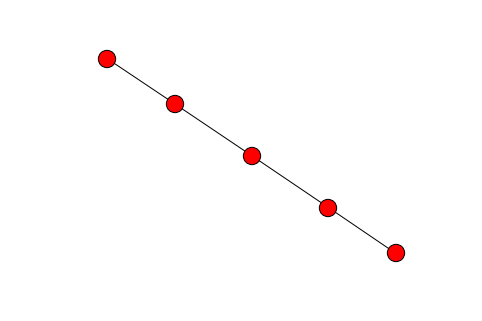

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
G = nx.Graph()
G.add_edge("A", "X") # student A went to school X
G.add_edge("A", "Y") # student A went to school Y
G.add_edge("B", "X") # student B went to school X
G.add_edge("C", "Y") # student C went to school X
nx.draw(G)

Because of an isssue with node labelling, we actually need to do a slightly more involved version.

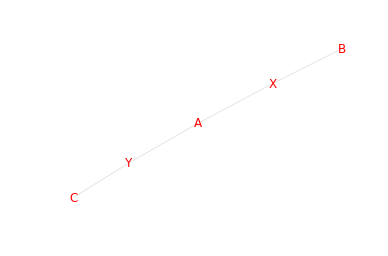

In [9]:
pos = nx.spring_layout(G)
nx.draw_networkx_labels(G, pos, font_color='r') # font colour is "r" for red
nx.draw_networkx_edges(G, pos, alpha=0.1) # set the line alpha transparency to .1
plt.axis('off') # don't show the axes for this plot
plt.show()

We can treat our topics similarly – instead of schools we have topics and instead of students we have terms.

## Graphing Topic Terms

The code below to generate the graph data shares some similarities with our code to print terms for each topic:

* go through each topic
    * go through each term
        * create a link (edge) between the topic and the term

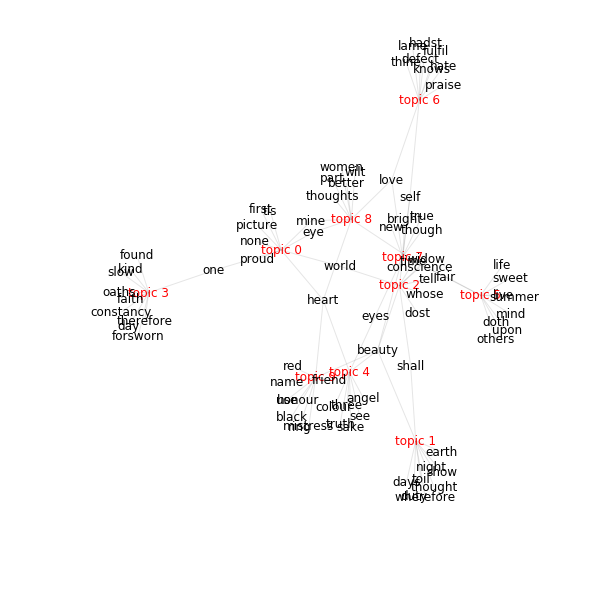

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def graph_terms_to_topics(lda, num_terms=10):
    
    # create a new graph and size it
    G = nx.Graph()
    plt.figure(figsize=(10,10))

    # generate the edges
    for i in range(0, lda.num_topics):
        topicLabel = "topic "+str(i)
        terms = [term for val, term in lda.show_topic(i, num_terms)]
        for term in terms:
            G.add_edge(topicLabel, term)
    
    pos = nx.spring_layout(G) # positions for all nodes
    
    # we'll plot topic labels and terms labels separately to have different colours
    g = G.subgraph([topic for topic, _ in pos.items() if "topic " in topic])
    nx.draw_networkx_labels(g, pos,  font_color='r')
    g = G.subgraph([term for term, _ in pos.items() if "topic " not in term])
    nx.draw_networkx_labels(g, pos)
    
    # plot edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.1)

    plt.axis('off')
    plt.show()

graph_terms_to_topics(sonnetsLda)

The terms on the outside only exist in one topic. Some of the terms are able to cluster closer to some topics due to the way force-directed graphs try to efficiently plot nodes (topic and term labels) to have the shotest lines and the least amount of overlap. Terms in the middle exist with multiple topics. Is this a useful way to read Shakespeare's sonnets?

## Next Steps

Try the following tasks to see if you can refine the topics:
* Experiment with arguments to get_lists_of_words()
    * *minLength* of words
    * stopwords
    * Parts-of-speech arguments (remember that these are [Treebank](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) codes)
    * Add an argument to the function (and try it) that determines if words are converted to lowercase
* Experiment with arguments to get_lda_from_lists_of_words(), in other words to [LdaModel()](http://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)
* Which tweaks seem to make the most difference?

Let's continue on to [Document Similarity](DocumentSimilarity.ipynb).

---
[CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/) From [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) by [Stéfan Sinclair](http://stefansinclair.name) &amp; [Geoffrey Rockwell](http://geoffreyrockwell.com)<br >Created March 23, 2015 and last modified December 9, 2015 (Jupyter 4)